# Open Traffic Reporter

## Map-Matching Validation

In [1]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import os
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
%matplotlib inline

In [33]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')
cityName = 'Levittown, NY'

### 1. Generate Random Routes

#### Generate routes from Google Maps POIs or Mapzen Venues

In [ ]:
# routeList = val.get_POI_routes_by_length('Paris', 1, 5, 20, gmapsKey)
routeList = val.get_routes_by_length(cityName, 1, 5, 20, mapzenKey)

#### Save or load a specific set of routes

In [6]:
# routeList = pickle.load(open('sf_routes.pkl','rb'))
# pickle.dump(routeList, open('sf_routes.pkl','wb'))

### 2. Iterate Through Routes and Score the Matches

In [ ]:
scoring = ['segments', 'distance traveled', 'undermatches', 'undermatch distance', 'overmatches', 'overmatch distance']
df = pd.DataFrame(columns=[
    'route','noise', 'sample_rate'] +
                  scoring + ['avg_density', 'route_url', 'trace_attr_url', 'reporter_url'])
outDfRow = -1
saveResults = True
noiseLevels = np.linspace(0, 100, 21)
sampleRates = [1, 5, 10, 20, 30]

for i, rteCoords in enumerate(routeList):
    stName = rteCoords[0].keys()[0].encode("ascii", "ignore")
    endName = rteCoords[1].keys()[0].encode("ascii", "ignore")
    shape, routeUrl = val.get_route_shape(rteCoords)
    if shape is None:
        print routeUrl
        continue
    edges, shapeCoords, traceAttrUrl = val.get_trace_attrs(shape, shapeMatch="map_snap")
    edges = val.get_coords_per_second(shapeCoords, edges, '2768')
    avgDensity = np.mean([edge['density'] for edge in edges])

    scores = []
    
    for noise in noiseLevels:
        noise = round(noise,3)
        routeName = '{0}_to_{1}'.format(stName, endName)
        
        for sampleRate in sampleRates:
            print("Route: {0} // Noise Level: {1} // Sample Rate: {2}".format(
                i, noise, sampleRate))
            Hz = round(1 / sampleRate, 3)
            outDfRow += 1
            df.loc[
                outDfRow, 
                ['route', 'noise','sample_rate','route_url','trace_attr_url']
            ] = [routeName, noise, sampleRate, routeUrl, traceAttrUrl]
            dfEdges = val.format_edge_df(edges)
            if dfEdges['num_segments'].max() > 1:
                break
            dfEdges, jsonDict, geojson, gpsMatchEdges = val.synthesize_gps(
                dfEdges, shapeCoords, '2768', noise=noise, sampleRate=sampleRate)
            if jsonDict is None or geojson is None:
                msg = "Trace attributes tried to call more edges than are present in the route shape".format(
                routeName)
                df.loc[outDfRow, scoring + ['reporter_url']] = [None] * 6 + [msg]
                continue
            segments, reportUrl = val.get_reporter_segments(jsonDict)
            if segments is None:
                continue
            elif segments == 0:
                msg = 'Reporter found 0 segments.'
                df.loc[outDfRow, scoring + ['reporter_url']] = [-1] * 6 + [reportUrl]
                continue
            segScore, distScore, undermatchScore, undermatchLenScore, overmatchScore, \
                overmatchLenScore = val.get_match_scores(segments, dfEdges, gpsMatchEdges)
            df.loc[outDfRow, scoring + ['reporter_url']] = [segScore, distScore, undermatchScore, undermatchLenScore,
                                                            overmatchScore, overmatchLenScore, reportUrl]
            df.loc[outDfRow, 'avg_density'] = avgDensity
            if saveResults:
                with open('../data/trace_{0}_to_{1}_w_{2}_m_noise_at_{3}_Hz.geojson'.format(
                    stName, endName, str(noise), str(Hz)), 'w+') as fp:
                    json.dump(geojson, fp)

Route: 0 // Noise Level: 0.0 // Sample Rate: 1
Route: 0 // Noise Level: 0.0 // Sample Rate: 5
Route: 0 // Noise Level: 0.0 // Sample Rate: 10
Route: 0 // Noise Level: 0.0 // Sample Rate: 20
Route: 0 // Noise Level: 0.0 // Sample Rate: 30
Route: 0 // Noise Level: 5.0 // Sample Rate: 1
Route: 0 // Noise Level: 5.0 // Sample Rate: 5
Route: 0 // Noise Level: 5.0 // Sample Rate: 10
Route: 0 // Noise Level: 5.0 // Sample Rate: 20
Route: 0 // Noise Level: 5.0 // Sample Rate: 30
Route: 0 // Noise Level: 10.0 // Sample Rate: 1
Route: 0 // Noise Level: 10.0 // Sample Rate: 5
Route: 0 // Noise Level: 10.0 // Sample Rate: 10
Route: 0 // Noise Level: 10.0 // Sample Rate: 20
Route: 0 // Noise Level: 10.0 // Sample Rate: 30
Route: 0 // Noise Level: 15.0 // Sample Rate: 1
Route: 0 // Noise Level: 15.0 // Sample Rate: 5
Route: 0 // Noise Level: 15.0 // Sample Rate: 10
Route: 0 // Noise Level: 15.0 // Sample Rate: 20
Route: 0 // Noise Level: 15.0 // Sample Rate: 30
Route: 0 // Noise Level: 20.0 // Sampl

### 3. Plot the Scores

#### Ensure data are numeric types

In [28]:
df['segments'] = 1 - df['segments'].astype(float)
df['overmatches'] = df['overmatches'].astype(float)
df['undermatches'] = df['undermatches'].astype(float)
df['distance traveled'] = df['distance traveled'].astype(float)
df['overmatch distance'] = df['overmatch distance'].astype(float)
df['undermatch distance'] = df['undermatch distance'].astype(float)
df['avg_density'] = df['avg_density'].astype(float)
df['noise'] = df['noise'].astype(float)
df['sample_rate'] = df['sample_rate'].astype(float)
df['score_density'] = df['segments'] * df['avg_density']

#### Boxplots by Sample Rate

In [35]:
# for rate in sampleRates:
#     Hz = round(1 / rate, 3)
#     fig, ax = plt.subplots(figsize=(12,8))
#     df[(df['sample_rate'] == rate) & (df['dist_score'] >= 0)].boxplot(column='dist_score',by='noise', ax=ax, grid=False)
#     ax.set_xlabel('Noise (m)', fontsize=15)
#     ax.set_ylabel('Match rate', fontsize=15)
#     ax.set_title('Sample Rate: {0} Hz'.format(Hz), fontsize=20)
#     fig.suptitle('')
# #     fig.savefig('./../data/score_vs_noise_{0}_Hz.png'.format(Hz))

#### Grid of Scoring Metrics

In [29]:
df['avg_density'].median()

10.709677419354838

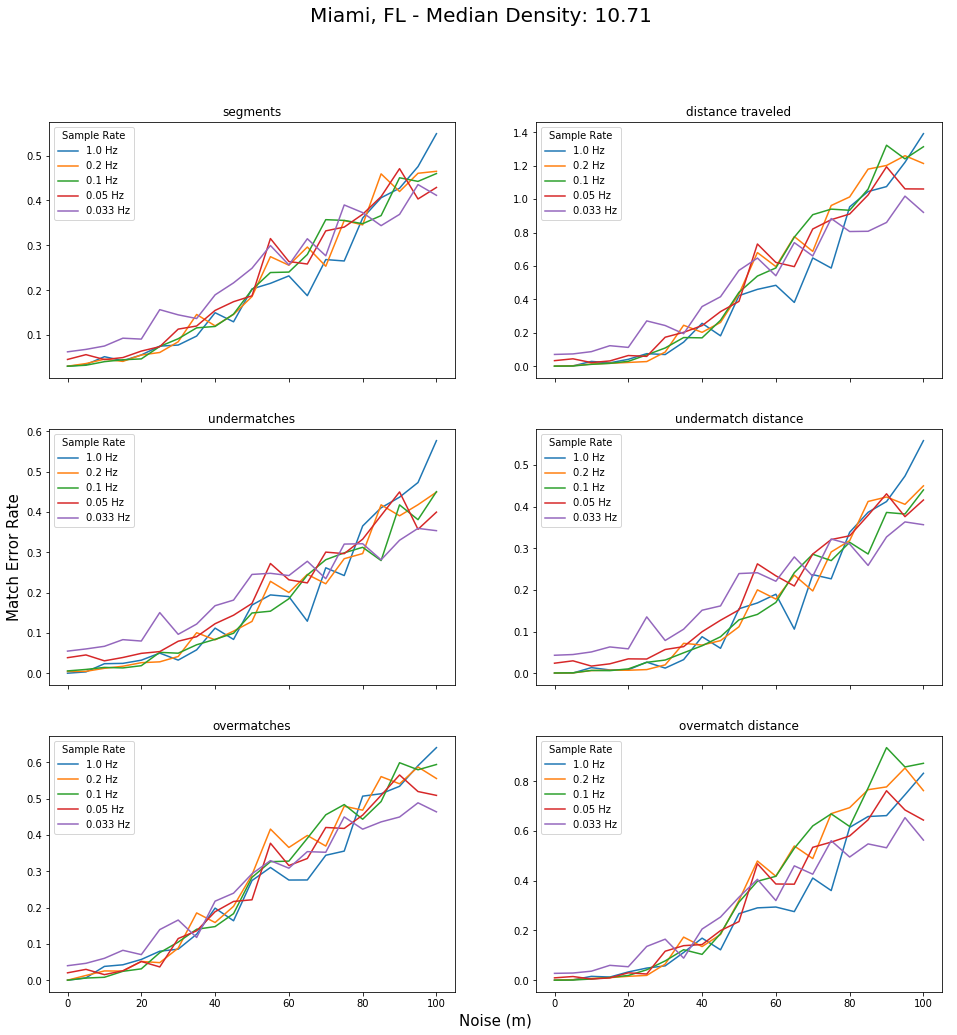

In [32]:
metricArr = np.asarray(scoring).reshape((3,2))
fig, axarr = plt.subplots(3,2, sharex=True, figsize=(16,16))
for i, row in enumerate(axarr):
    for j, col in enumerate(row):
        metric = metricArr[i,j]

        data = df[['noise',metric,'sample_rate']].groupby(['sample_rate','noise']).agg('mean').reset_index()
        for rate in sampleRates:
            axarr[i,j].plot(data.loc[data['sample_rate'] == rate, 'noise'],
                    data.loc[data['sample_rate'] == rate, metric],
                   label=str(round(1 / rate, 3)) + ' Hz')
        axarr[i,j].legend(title='Sample Rate')
        axarr[i,j].set_title(metric)

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_xlabel('Noise (m)', fontsize=15)
ax.set_ylabel('Match Error Rate', fontsize=15)
fig.suptitle('{0} - Median Density: {1}'.format(
    cityName, round(df['avg_density'].median(),2)), fontsize=20)
fig.savefig('{0}_match_errors_by_sample_rate.png'.format(cityName))

### 4. Check for Pattern Failure 

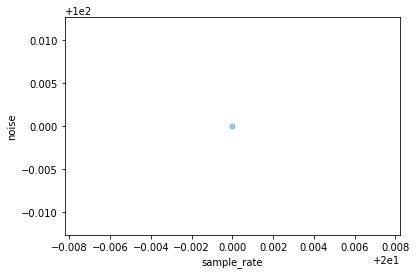

In [9]:
try:
    df[df['segments'] == 1].plot('sample_rate','noise',kind='scatter',s=25, alpha=0.4)
except TypeError:
    pass

In [10]:
try:
    df[df['segments'] == -1].plot('sample_rate','noise',kind='scatter',s=25, alpha=0.4)
except TypeError:
    pass

### 5. Visualize Routes

In [46]:
geojsonList = [trace for trace in os.listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(geojsonList)
val.generate_route_map(fname, 14)

In [16]:
fname

'../data/trace_Brookside Capital Inc_to_Sunnyside Properties_w_50.0_m_noise_at_0.1_Hz.geojson'

### 6. Save the Scores to Master File

In [20]:
df.columns = [x.strip().replace(' ', '_') for x in df.columns]
df.to_csv('../data/master_scores.csv', index=False)